In [1]:
import utils.file_utils as fu
import perceptrons.multilayer_perceptron as mlp
import numpy as np
import metrics as m
import graphing as g

In [7]:
config_file_path = "ex_2/resources/config.json"
config_file = fu.parse_config(config_file_path)

path_to_data = config_file["path_to_data"]
epoch_limit = int(config_file["epoch_limit"])
execution_count = int(config_file["execution_count"])
momentum = bool(config_file["momentum"])
cross_validation_k = int(config_file["cross_validation"])
learn_rate = float(config_file["learn_rate"])
adaptive_learn_rate = bool(config_file["adaptive_learn_rate"])
if adaptive_learn_rate:
    update_learn_rate = (lambda lr, k: lr + 0.3 if k >= 3 else (lr - lr*0.1 if k <=-3 else 0)) 
else:
    update_learn_rate = None
if config_file["activation_function"] == "linear":
    activation_function = (lambda x: x)
    activation_derivative = (lambda x: 1)
elif config_file["activation_function"] == "sigmoid":
    activation_function = (lambda x: 1/(1+np.exp(-2*x)))
    activation_derivative = (lambda x: 2*(1/(1+np.exp(-2*x)))*(1-(1/(1+np.exp(-2*x)))) )


In [8]:
training, expected = fu.parse_training_set_from_file(path_to_data)
p = mlp.MultiLayerPerceptron(learning_rate=learn_rate, hidden_layers=[], input_dim=len(training[0]), output_dim=len(expected[0]), update_frequency=0, activation_function=activation_function, activation_function_derivative=activation_derivative, update_learn_rate=update_learn_rate, scale_output=True,momentum=momentum)

In [9]:

open(path_to_data+"/error_vs_iteration.txt", "w").close()
p.train(training, expected, epoch_limit, callback=(lambda e, error, weights, output: fu.write_error_vs_iteration(path_to_data, error, e)))

({0: array([[-0.24687406],
         [ 0.25334888],
         [ 0.25363125],
         [ 0.25325512]])},
 0.02906451781855972)

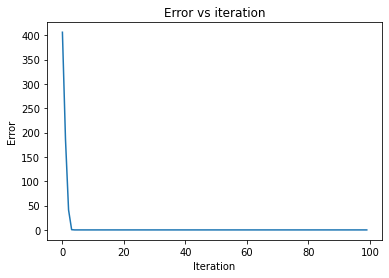

In [10]:
g.error_vs_iteration(path_to_data, False)

In [6]:
errors = []
for i in range(execution_count):
    w, e = p.train(training, expected, epoch_limit, callback=None)
    errors.append(e)
f = open(path_to_data+"/learning_rates.txt", "a")
f.write("{},{},{}\n".format(learn_rate, np.mean(errors), np.std(errors)))
f.close()

KeyboardInterrupt: 

In [ ]:
if config_file["activation_function"] == "sigmoid":
  
    training_groups, expected_groups = m.cross_validation(training,cross_validation_k,expected)
    err_mins = []
    rmsd_mins = []
    for i in range(execution_count):
        err_min = None
        rmsd_min = None
        for i, test_group in enumerate(training_groups):
            errors =[]
            t = training_groups[:i] + training_groups[i+1:]
            training_set = [item for sublist in t for item in sublist]
            e = expected_groups[:i] + expected_groups[i+1:]
            expected_set = [item for sublist in e for item in sublist]
            print(len(training_set))
            print(len(training_set[0]))
            w, err = p.train(training_set, expected_set, epoch_limit, callback=None)
        
            # Test
            for j, test_entry in enumerate(test_group):
                prediction = p.forward_propagation(test_entry)
                expected_output = expected_groups[i][j]
                errors.append(np.abs(np.subtract(prediction , expected_output)))

            # mean_error = m.mean_error(errors)
            max_error = m.max_error(errors)
            # min_error = m.min_error(errors)
            # mse_error = m.mse(errors)
            rmsd_error = m.rmsd(errors)
            if err_min == None or err < err_min:
                err_min = err
            if rmsd_min == None or rmsd_error < rmsd_min:
                rmsd_min = rmsd_error
        err_mins.append(err_min)
        rmsd_mins.append(rmsd_min)
   


In [ ]:
f = open(path_to_data+"/k_vs_errors.txt", "a")
f.write("{},{},{},{},{}\n".format(cross_validation_k, np.mean(err_mins), np.std(err_mins), np.mean(rmsd_mins), np.std(rmsd_mins)))
f.close()